In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#

import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys


0.8889016802079537 -0.8889016802079495


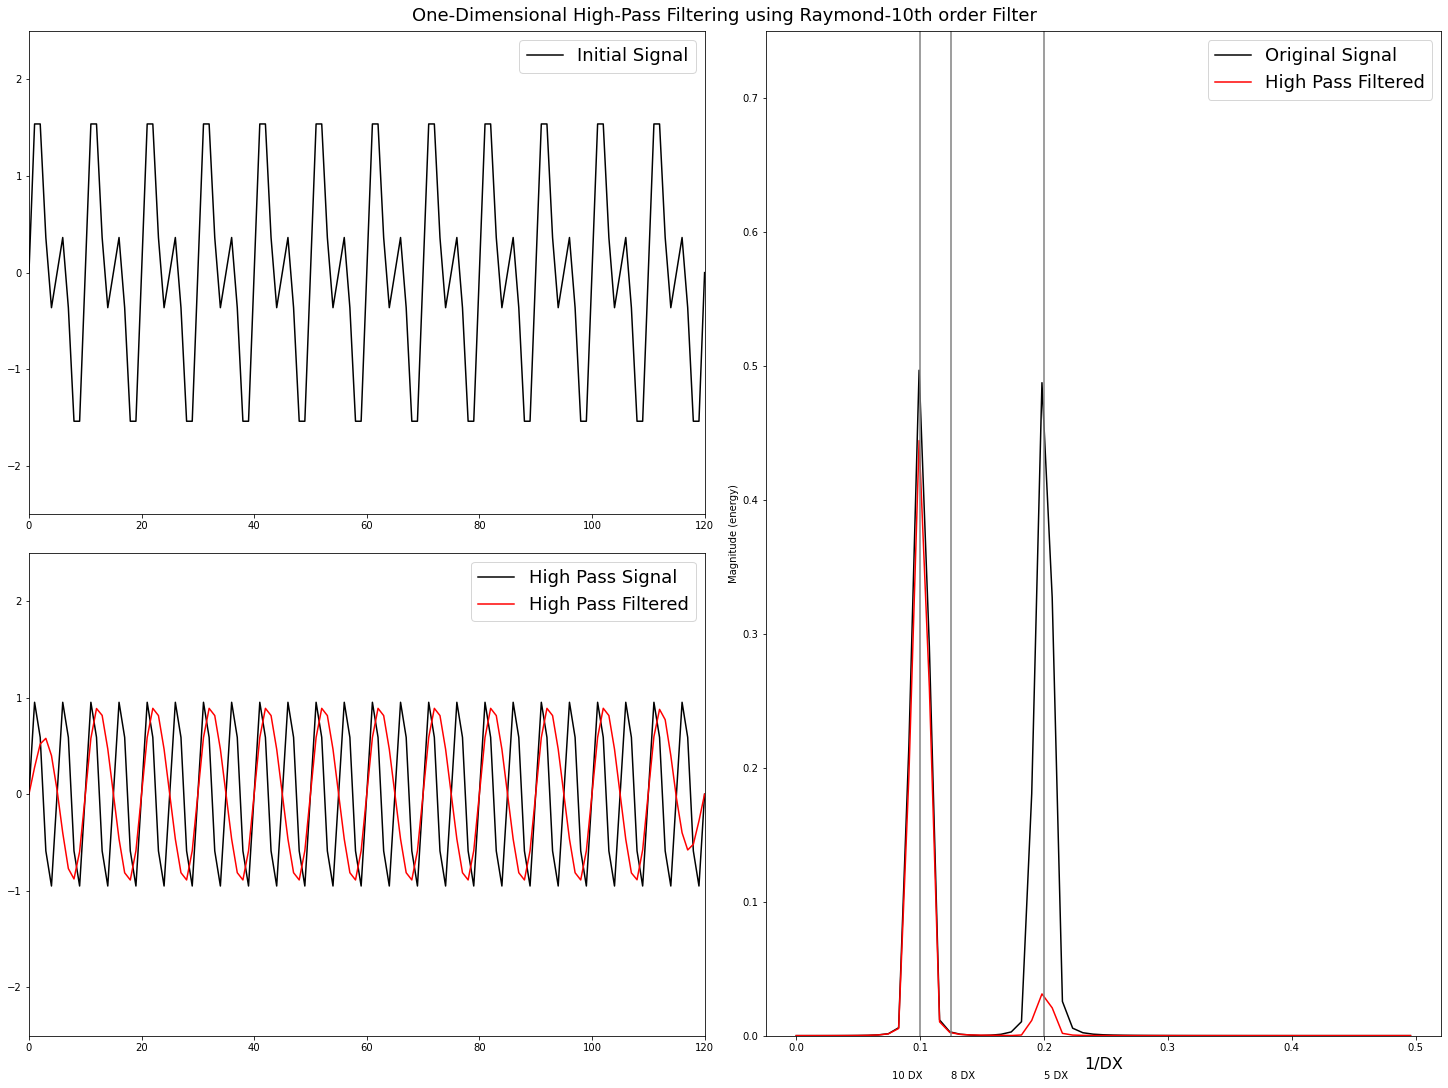

In [12]:
from filter.RaymondFilters import RaymondFilter6, RaymondFilter10, RaymondFilter6F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#        AMP   DX
wave0 = [1.0,  5.0]
wave1 = [0.0,  8.0]
wave2 = [1.0, 10.0]

ylim  = [-2.5,2.5]

x     = np.arange(121)

xlim  = [0,x[-1]]

eps   = 100.0

bc_reflect = False

field0 = wave0[0]*np.sin(2.0*np.pi*x/wave0[1])
field1 = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) 
field2 = wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

field = field0 + field1 + field2

ffield = RaymondFilter6F(field.copy(), eps, bc_reflect=bc_reflect)

fig = plt.figure(constrained_layout=True,figsize=(20,15))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])

ax1.plot(x, field, color='k', label='Total Signal')
ax1.legend(['Initial Signal'], fontsize=18)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

#-------------------------------------------------------------------------------------
# High pass plot

ax2.plot(x, field0+field1, color='k', label='High Pass Signal')
ax2.plot(x, ffield, color='r', label='High Pass Filtered')

print(ffield.max(), ffield.min())

ax2.set_xlim(xlim)
ax2.legend(fontsize=18)
ax2.set_ylim(ylim)

#-------------------------------------------------------------------------------------
# Spectrum plot

ax3 = fig.add_subplot(gs[:, 1])

line1 = ax3.magnitude_spectrum(field, Fs=1.0, color='k', label='Original Signal')
line2 = ax3.magnitude_spectrum(ffield, Fs=1.0, color='r', label='High Pass Filtered')
ax3.legend(fontsize=18)
ax3.set_ylim(.0,0.75)
ax3.plot([1.0/wave1[1],1.0/wave1[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave2[1],1.0/wave2[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave0[1],1.0/wave0[1]], [0.0, 1.0], color='grey')
ax3.text(1.0/wave2[1]-0.01, -0.03, "%d DX" % (int(wave2[1])), va="center", ha="center")
ax3.text(1.0/wave1[1]+0.01, -0.03, "%d DX" % (int(wave1[1])), va="center", ha="center")
ax3.text(1.0/wave0[1]+0.01, -0.03, "%d DX" % (int(wave0[1])), va="center", ha="center")
ax3.set_xlabel("1/DX", fontsize=16)

plt.suptitle("One-Dimensional High-Pass Filtering using Raymond-10th order Filter", fontsize=18)
plt.show()



In [36]:

raymond1d_lowpass?

Call signature: raymond1d_lowpass(*args, **kwargs)
Type:           fortran
String form:    <fortran object>
Docstring:     
result = raymond1d_lowpass(xy,eps,[n])

Wrapper for ``raymond1d_lowpass``.

Parameters
----------
xy : input rank-1 array('d') with bounds (n)
eps : input float

Other Parameters
----------------
n : input int, optional
    Default: len(xy)

Returns
-------
result : rank-1 array('d') with bounds (n)


[autoreload of filter.RaymondFilters failed: Traceback (most recent call last):
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/Louis.Wicker/miniconda3/envs/main/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._b

[[1. 0. 0. ... 0. 0. 0.]
 [1. 2. 1. ... 0. 0. 0.]
 [1. 4. 6. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 6. 4. 1.]
 [0. 0. 0. ... 1. 2. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
-0.0 0.0 1.658163297481701 1.5877852522924734


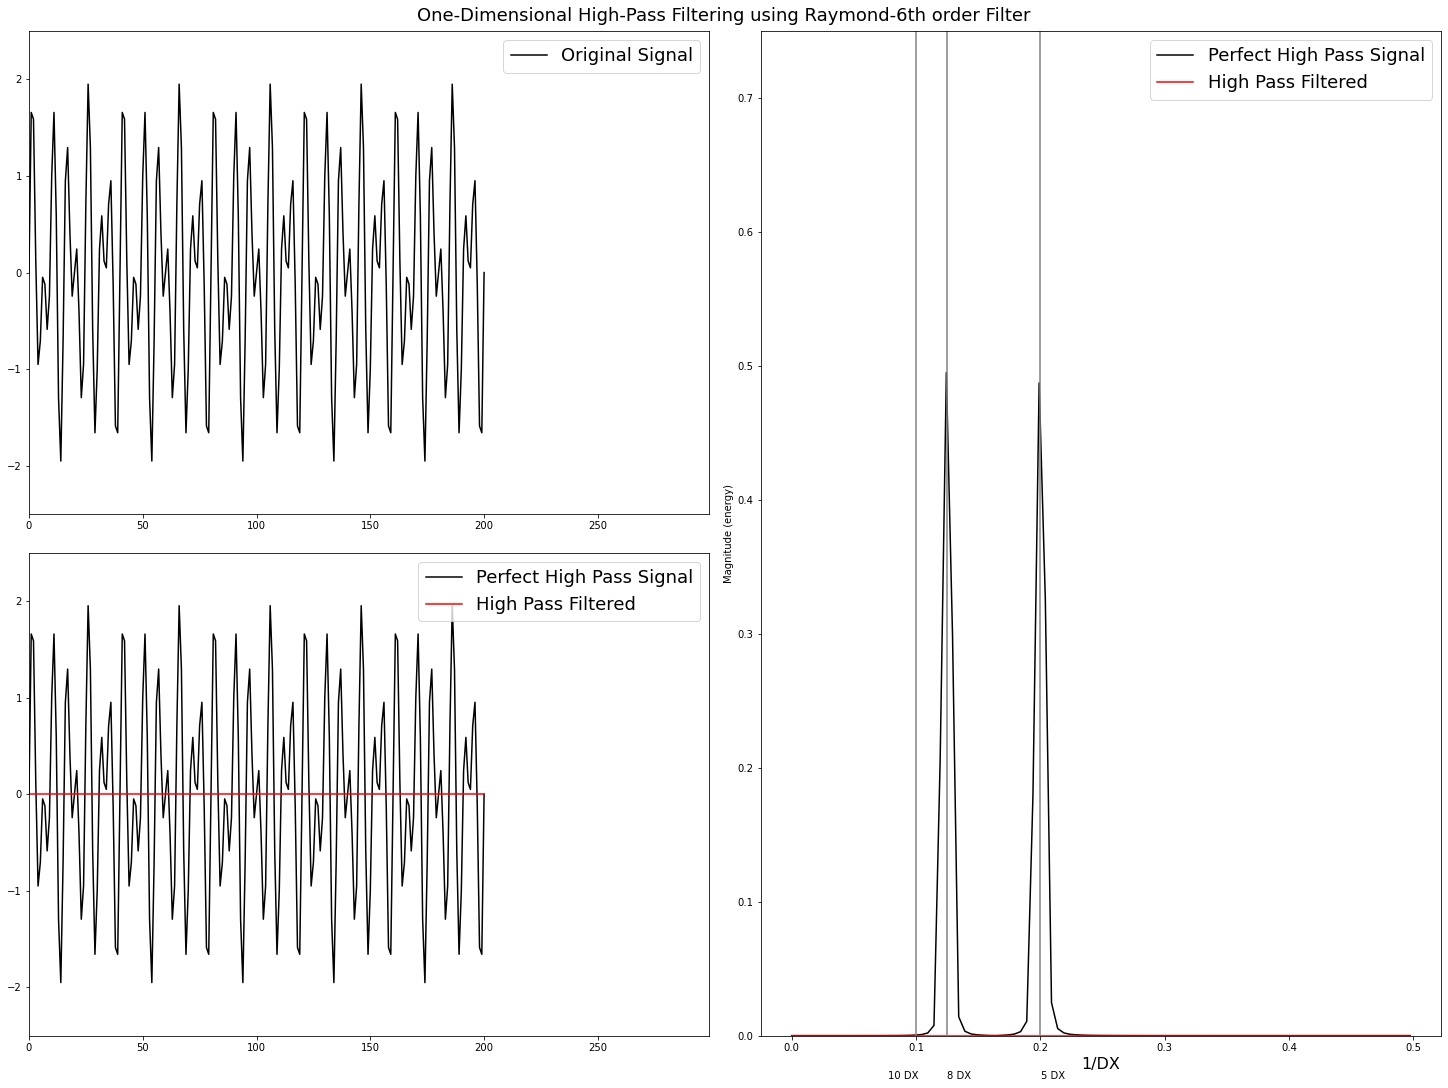

In [32]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

wave0 = [1.0,5.0]
wave1 = [1.0,8.0]
wave2 = [0.0,10.0]
ylim  = [-2.5,2.5]
x     = np.arange(201)
xlim  = [0,299]
eps   = 0.0

field0 = wave0[0]*np.sin(2.0*np.pi*x/wave0[1])
field1 = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) 
field2 = wave2[0]*np.sin(2.0*np.pi*x/wave2[1])

field = field0 + field1 + field2

ffield = field - RaymondFilter6(field.copy(), eps)

# Plot answers

fig = plt.figure(constrained_layout=True,figsize=(20,15))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])

ax1.plot(x, field, color='k', label='Original Signal')
ax1.legend(['Original Signal'], fontsize=18)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

#-------------------------------------------------------------------------------------
# High pass plot
ax2.plot(x, field0+field1, color='k', label='Perfect High Pass Signal')
ax2.plot(x, ffield, color='r', label='High Pass Filtered')

ax2.set_xlim(xlim)
ax2.legend(fontsize=18)
ax2.set_ylim(ylim)

#-------------------------------------------------------------------------------------
# Spectrum plot

ax3 = fig.add_subplot(gs[:, 1])

line1 = ax3.magnitude_spectrum(field, Fs=1.0, color='k', label='Perfect High Pass Signal')
line2 = ax3.magnitude_spectrum(ffield, Fs=1.0, color='r', label='High Pass Filtered')
ax3.legend(fontsize=18)
ax3.set_ylim(.0,0.75)
ax3.plot([1.0/wave1[1],1.0/wave1[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave2[1],1.0/wave2[1]], [0.0, 1.0], color='grey')
ax3.plot([1.0/wave0[1],1.0/wave0[1]], [0.0, 1.0], color='grey')
ax3.text(1.0/wave2[1]-0.01, -0.03, "%d DX" % (int(wave2[1])), va="center", ha="center")
ax3.text(1.0/wave1[1]+0.01, -0.03, "%d DX" % (int(wave1[1])), va="center", ha="center")
ax3.text(1.0/wave0[1]+0.01, -0.03, "%d DX" % (int(wave0[1])), va="center", ha="center")
ax3.set_xlabel("1/DX", fontsize=16)

plt.suptitle("One-Dimensional High-Pass Filtering using Raymond-6th order Filter", fontsize=18)
plt.show()
